In [57]:
import re
import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import f_oneway, shapiro, bartlett


In [2]:
# faz a requisição HTTP para a página principal
response = requests.get('https://cruzeiropedia.org/Categoria:Temporadas')

# faz o parsing do HTML da página principal
soup = BeautifulSoup(response.content, 'html.parser')

In [3]:
# encontra todas as tags <a> que contêm o nome das temporadas (identifica os links) 
temporadas = soup.find_all('a', {'title': 
                                 ['Categoria:Temporada 2011',
                                  'Categoria:Temporada 2012',
                                  'Categoria:Temporada 2013',
                                  'Categoria:Temporada 2014',
                                  'Categoria:Temporada 2015',
                                  'Categoria:Temporada 2016',
                                  'Categoria:Temporada 2017', 
                                  'Categoria:Temporada 2018', 
                                  'Categoria:Temporada 2019', 
                                  'Categoria:Temporada 2020', 
                                  'Categoria:Temporada 2021', 
                                  'Categoria:Temporada 2022',
                                  'Categoria:Temporada 2023']
                                  }
                                  )

In [4]:
# lista para armazenar os dados encontrados
anos = []
datas = []
pubPagantes = []
pubPresentes = []
placares = []

# percorre a lista de temporadas
for temporada in temporadas:
    # obtém o link da temporada
    link_temporada = temporada.get('href')
    
    # faz a requisição HTTP para a página da temporada
    response_temporada = requests.get('https://cruzeiropedia.org' + link_temporada)
    
    # faz o parsing do HTML da página da temporada
    soup_temporada = BeautifulSoup(response_temporada.content, 'html.parser')
    
    # identifica os jogos que o cruzeiro foi mandante na temporada em questão
    jogos = soup_temporada.find_all('a', {'title':re.compile('^Cruzeiro .*')})

    # entra em cada um dos jogos
    for jogo in jogos:
        # obtém o link do jogo
        link_jogos = jogo.get('href')
        # faz a requisição HTTP para a página do jogo
        response_jogos = requests.get('https://cruzeiropedia.org' + link_jogos)
        # faz o parsing do html da página do jogo
        soup_jogos = BeautifulSoup(response_jogos.content, 'html.parser')
        
        # retira a informação do ano
        ano = soup_jogos.find('b', string='Data:').find_next_sibling().find_next_sibling().text.strip()
        anos.append(ano)

        # retira a informação da data
        data = soup_jogos.find('b', string='Data:').find_next_sibling().text.strip()
        datas.append(data)

        # retira a informação do publico pagante
        pubPagante = soup_jogos.find('b', string='Público pagante:').next_sibling.strip()
        pubPagantes.append(pubPagante)
        
        # retira a informação do publico presente
        pubPresente = soup_jogos.find('b', string='Público Presente:').next_sibling.strip()
        pubPresentes.append(pubPresente)

        # retira a informação do placar do jogo
        placar_element = soup_jogos.find('div', class_='divFicha')
        placar = placar_element.find('b').text
        placares.append(placar)



In [10]:
# Formatando as informações retiradas em um dataframe
df_raw = pd.DataFrame({'publico_presente': pubPresentes,
                   'publico_pagante':pubPagantes,
                   'placar':placares})

In [31]:
# Salvando esse dataframe como backup 

df = df_raw.copy()

In [32]:
# Analisando como está a disposição dos dados
df.head(20)

,publico_presente,publico_pagante,placar
0,Não disponível,4.151,3 × 0
1,Não disponível,9.793,3 × 4
2,Não disponível,10.955,5 × 0
3,2.045,1.664,2 × 0
4,13.271,12.067,4 × 0
5,Não disponível,1.217,7 × 0
6,Não disponível,8.198,6 × 1
7,Não disponível,3.641,3 × 0
8,Não disponível,5.098,4 × 1
9,Não disponível,4.037,5 × 1


In [98]:
# Conferindo dados nulos nas colunas
df.isnull().sum()

publico_pagante    0
resultado          0
dtype: int64
38


In [33]:
# Excluindo a coluna publico presente
df.drop('publico_presente', axis=1,inplace=True)

In [34]:
# Retirando a informação da quantidade de sócios entre parênteses para manter apenas dados numéricos referentes ao público
df[['publico_pagante','erro1','erro2']] = df['publico_pagante'].str.split(' ',expand=True)
df.drop(['erro1','erro2'],axis=1,inplace=True)

In [39]:
# Retirando o separador de milhar para que a coluna consiga ser usada como tipo numérico
for i in range(0,len(df)):
    df['publico_pagante'][i] = df['publico_pagante'][i].replace('.','')

In [ ]:
# Separando a quantidade de gols de cada equipe em colunas diferentes
df[['golsCruzeiro','golsVisitante']] = df['placar'].str.split(' × ',expand=True)
df.drop('placar',axis=1,inplace=True)

In [54]:
# Criando uma nova coluna que determina se for vitória, derrota ou empate do time mandante - cruzeiro
df['resultado'] = None
for i in range(0,len(df)):
    if df['golsCruzeiro'][i] > df['golsVisitante'][i]:
        df['resultado'][i] = 'Vitória'
    elif df['golsCruzeiro'][i] < df['golsVisitante'][i]:
        df['resultado'][i] = 'Derrota'
    else:
        df['resultado'][i] = 'Empate'

In [56]:
# Excluindo as colunas de gols e mantendo apenas as duas colunas a serem usadas no teste ANOVA (Resutlado do jogo e Publico)
df.drop(['golsCruzeiro','golsVisitante'], axis=1, inplace=True)

In [76]:
# Conferindo tipos de dados atuais
df.dtypes

publico_pagante    object
resultado          object
dtype: object

In [79]:
# Alterando o tipo de dados
df['publico_pagante'] = df['publico_pagante'].astype('float')
df['resultado'] = df['resultado'].astype('category')

In [105]:
grupo1 = df['publico_pagante']

# Teste de Shapiro-Wilk para verificar normalidade
_, p_valor = shapiro(grupo1)

# Interpretar os resultados
alpha = 0.05  # Nível de significância
if p_valor > alpha:
    print("Os dados parecem ser normalmente distribuídos (não rejeitar H0)")
else:
    print("Os dados não parecem ser normalmente distribuídos (rejeitar H0)")

# Verificação do p-valor
print(f'P-valor do teste de Shapiro-Wilk: {p_valor}')

Os dados não parecem ser normalmente distribuídos (rejeitar H0)
P-valor do teste de Shapiro-Wilk: 5.87961008547723e-14


c:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


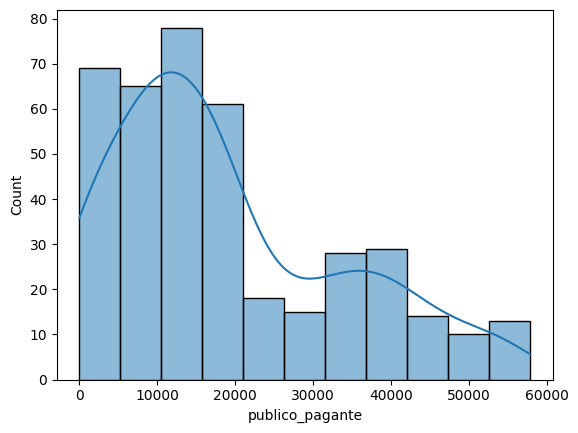

In [91]:
sns.histplot(data=df,x='publico_pagante', kde=True);

In [107]:
# Lista de grupos (resultados)
grupos = df['resultado'].unique()

# Lista para armazenar as amostras de cada grupo
amostras = []

# Extrair amostras para cada grupo
for grupo in grupos:
    amostras_grupo = df[df['resultado'] == grupo]['publico_pagante']
    amostras.append(amostras_grupo)

# Realize o teste de Bartlett
estatistica_bartlett, p_valor_bartlett = bartlett(*amostras)

# Imprima os resultados
print("Estatística de teste de Bartlett:", estatistica_bartlett)
print("P-valor de Bartlett:", p_valor_bartlett)

# Interprete os resultados
alpha = 0.05  # Nível de significância
if p_valor_bartlett < alpha:
    print("Rejeitar H0: As variâncias são diferentes entre os grupos.")
else:
    print("Não rejeitar H0: Não há evidência de diferença nas variâncias entre os grupos.")

Estatística de teste de Bartlett: 1.292720225387903
P-valor de Bartlett: 0.5239494269914261
Não rejeitar H0: Não há evidência de diferença nas variâncias entre os grupos.
